Reference: [Neural machine translation with attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention)

In [1]:
from google.colab import drive
drive.mount("/gdrive")

Mounted at /gdrive


In [2]:
import pickle
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
# Paths to the training input and output pickled files
train_input_path = r"/gdrive/MyDrive/Colab Notebooks/Train_input"
train_output_path = r"/gdrive/MyDrive/Colab Notebooks/Train_output"

test_input_path = r"/gdrive/MyDrive/Colab Notebooks/Test_input"
test_output_path = r"/gdrive/MyDrive/Colab Notebooks/Test_output"

# Load train input and output data using pickle
train_input = pickle.load(open(train_input_path, 'rb'))
train_output = pickle.load(open(train_output_path, 'rb'))

# Combine train inputs and outputs into text pairs
text_pairs = list(zip(train_input, train_output))

# Shuffle the text pairs and split into train and validation sets
random.seed(8)
random.shuffle(text_pairs)

# Define the number of samples for validation and test sets
num_test_samples = int(0.1 * len(text_pairs))
num_val_samples = int(0.2 * len(text_pairs))
num_train_samples = len(text_pairs) - num_val_samples - num_test_samples

# Split text pairs into train, validation, and test sets
test_pairs = text_pairs[:num_test_samples]
val_pairs = text_pairs[num_test_samples:num_test_samples + num_val_samples]
train_pairs = text_pairs[num_test_samples + num_val_samples:]

# Print the number of samples in train, validation, and test sets
print(f'Number of training samples: {len(train_pairs)}')
print(f'Number of validation samples: {len(val_pairs)}')
print(f'Number of test samples: {len(test_pairs)}')

# Separate train, validation, and test inputs and outputs
train_inputs = [pair[0] for pair in train_pairs]
train_outputs = [pair[1] for pair in train_pairs]

val_inputs = [pair[0] for pair in val_pairs]
val_outputs = [pair[1] for pair in val_pairs]

test_inputs = [pair[0] for pair in test_pairs]
test_outputs = [pair[1] for pair in test_pairs]

with open(test_input_path, 'wb') as f:
    pickle.dump(test_inputs, f)

with open(test_output_path, 'wb') as f:
    pickle.dump(test_outputs, f)

Number of training samples: 78400
Number of validation samples: 22400
Number of test samples: 11200


In [4]:
display(train_inputs[1], train_outputs[1], val_inputs[1], val_outputs[1])

'a h c e b d a f a h c f c e b d a h b d b d a d b d c d '

'c e b d c f c e b d a h f g h b d b d b d c d a d l m a h j k ed a f i ee a h d e ef '

'a h a h a h c f c f a h b d b d b d c g b d b d c e '

'c f c f b d b d b d a h f g h a h d e i c g b d a h j k l b d c e a h m ed ee '

In [5]:
# Define the buffer size and batch size for the dataset
BUFFER_SIZE = len(train_inputs)
BATCH_SIZE = 64

# Create TensorFlow datasets for training and validation with selected inputs and outputs
# Shuffle the training data with the defined buffer size and create batches of defined batch size
train_raw = (
    tf.data.Dataset
    .from_tensor_slices((train_inputs, train_outputs))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

# Create a TensorFlow dataset for validation by shuffling the validation data and batching
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((val_inputs, val_outputs))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [6]:
# Display the lengths of the train and validation datasets
display(len(train_raw), len(val_raw))

1225

350

In [7]:
def preprocessing(text):
    # Strip whitespace: Remove leading and trailing spaces.
    text = tf.strings.strip(text)

    # Add start and end tokens to the text.
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')

    return text

In [8]:
# Define the maximum vocabulary size for tokenizing the text
max_vocab_size = 100

# Initialize a TextVectorization layer for processing context text
context_text_processor = tf.keras.layers.TextVectorization(
    standardize=preprocessing,  # Apply a specified preprocessing function
    max_tokens=max_vocab_size,  # Limit the vocabulary size to a maximum number of tokens
    ragged=True  # Handle variable-length sequences with ragged tensors
)

In [9]:
# Adapt the text processor to the training dataset's context data
context_text_processor.adapt(train_raw.map(lambda context, target: context))

In [10]:
# Initialize a TextVectorization layer for target text with defined parameters
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=preprocessing,  # Define standardization function for text preprocessing
    max_tokens=max_vocab_size,  # Define the maximum vocabulary size
    ragged=True  # Allow ragged tensors as output
)

# Adapt the target_text_processor to the training dataset by extracting targets
target_text_processor.adapt(train_raw.map(lambda context, target: target))

In [11]:
# Define a function to process text data
def process_text(context, target):
    # Process context text using a text processor and convert it to a tensor
    context = context_text_processor(context).to_tensor()

    # Process target text using a text processor
    target = target_text_processor(target)

    # Prepare input and output target tensors for training
    targ_in = target[:, :-1].to_tensor()  # Use all elements except the last as input
    targ_out = target[:, 1:].to_tensor()  # Use all elements except the first as output

    return (context, targ_in), targ_out  # Return tuple containing input and output targets

# Map the process_text function to the training dataset to process the text data
train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)

# Map the process_text function to the validation dataset to process the text data
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [12]:
# Define the number of units for encoder, cross attention and decoder
UNITS = 256

In [13]:
# Define the Encoder class
class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units):
        super(Encoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.units = units

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero=True)

        # The RNN layer processes those vectors sequentially.
        self.rnn = tf.keras.layers.Bidirectional(
            merge_mode='sum',
            layer=tf.keras.layers.GRU(units,
                                       # Return the sequence and state
                                       return_sequences=True,
                                       recurrent_initializer='glorot_uniform'))

    def call(self, x):
        # 2. The embedding layer looks up the embedding vector for each token.
        x = self.embedding(x)

        # 3. The GRU processes the sequence of embeddings.
        x = self.rnn(x)

        # 4. Returns the new sequence of embeddings.
        return x

    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]
        context = self.text_processor(texts).to_tensor()
        context = self(context)
        return context

In [14]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)

In [15]:
# Define the CrossAttention layer class
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__()

        # Multi-head attention mechanism
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)

        # Layer normalization for post-attention processing
        self.layernorm = tf.keras.layers.LayerNormalization()

        # Addition layer for skip connection
        self.add = tf.keras.layers.Add()

    def call(self, x, context):
        # Perform multi-head attention operation
        attn_output, attn_scores = self.mha(
            query=x,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for visualization or analysis
        attn_scores = tf.reduce_mean(attn_scores, axis=1)
        # shape_checker(attn_scores, 'batch t s')  # Reduced attention scores shape
        self.last_attention_weights = attn_scores

        # Skip connection: add attention output to the input and normalize
        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

In [16]:
# Create an instance of the CrossAttention layer
attention_layer = CrossAttention(UNITS)

In [17]:
# `Decoder` class' initializer creates all the necessary layers.
class Decoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units):
        super(Decoder, self).__init__()

        # Store text processor information and vocabulary size
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()

        # Define layers for converting tokens to IDs and vice versa
        self.word_to_id = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]')
        self.id_to_word = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]',
            invert=True)

        # Define start and end tokens for sequences
        self.start_token = self.word_to_id('[START]')
        self.end_token = self.word_to_id('[END]')

        self.units = units

        # 1. The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero=True)

        # 2. The RNN keeps track of what's been generated so far.
        self.rnn = tf.keras.layers.GRU(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        # 3. The RNN output will be the query for the attention layer.
        self.attention = CrossAttention(units)

        # 4. This fully connected layer produces the logits for each output token.
        self.output_layer = tf.keras.layers.Dense(self.vocab_size)

    def call(self,
            context, x,
            state=None,
            return_state=False):

        # 1. Lookup the embeddings for the input sequence
        x = self.embedding(x)

        # 2. Process the target sequence using the RNN layer
        x, state = self.rnn(x, initial_state=state)

        # 3. Use the RNN output as the query for the attention mechanism over the context
        x = self.attention(x, context)
        self.last_attention_weights = self.attention.last_attention_weights

        # 4. Generate logit predictions for the next token
        logits = self.output_layer(x)

        # Return logits and optionally the state
        if return_state:
            return logits, state
        else:
            return logits

    def get_initial_state(self, context):
        # Get the batch size from the context
        batch_size = tf.shape(context)[0]

        # Create start tokens, done tensor, and embed the start tokens
        start_tokens = tf.fill([batch_size, 1], self.start_token)
        done = tf.zeros([batch_size, 1], dtype=tf.bool)
        embedded = self.embedding(start_tokens)

        # Return initial state for the decoder RNN
        return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

    def tokens_to_text(self, tokens):
        # Convert tokens to words using the id_to_word mapping
        words = self.id_to_word(tokens)

        # Concatenate words to form a text sequence
        result = tf.strings.reduce_join(words, axis=-1, separator=' ')

        # Remove leading [START] and trailing [END] tokens from the text
        result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
        result = tf.strings.regex_replace(result, ' *\[END\] *$', '')

        return result

    def get_next_token(self, context, next_token, done, state, temperature=0.0):
        # Get logits and state from the decoder
        logits, state = self(
            context, next_token,
            state=state,
            return_state=True)

        # Adjust logits based on temperature for sampling diversity
        if temperature == 0.0:
            # If temperature is 0, use argmax to get the most probable token
            next_token = tf.argmax(logits, axis=-1)
        else:
            # Apply temperature to logits for diverse sampling
            logits = logits[:, -1, :] / temperature
            next_token = tf.random.categorical(logits, num_samples=1)

        # If a sequence produces an `end_token`, set it as `done`
        done = done | (next_token == self.end_token)

        # Once a sequence is done, it only produces 0-padding
        next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

        return next_token, done, state

In [18]:
# Instantiate the Decoder class
decoder = Decoder(target_text_processor, UNITS)

In [19]:
class Translator(tf.keras.Model):
    def __init__(self, units, context_text_processor, target_text_processor):
        super().__init__()

        # Build the encoder and decoder using the defined units
        encoder = Encoder(context_text_processor, units)
        decoder = Decoder(target_text_processor, units)

        # Set the encoder and decoder
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        # Unpack the inputs into context and x (target tokens)
        context, x = inputs

        # Encode the context
        context = self.encoder(context)

        # Get logits using the decoder based on the context and target tokens (x)
        logits = self.decoder(context, x)

        try:
            # Remove the Keras mask to prevent scaling of loss and accuracy
            del logits._keras_mask
        except AttributeError:
            # If no Keras mask attribute exists, pass
            pass

        return logits

    def translate(self,
                  texts, *,
                  max_length=100,
                  temperature=0.0):
        # Process the input texts by converting them into context embeddings
        context = self.encoder.convert_input(texts)
        batch_size = tf.shape(texts)[0]  # Get the batch size from the input texts

        # Initialize empty lists to store tokens and attention weights
        tokens = []  # List to collect generated tokens
        attention_weights = []  # List to collect attention weights for each token

        # Get initial values for next_token, done, and state from the decoder
        next_token, done, state = self.decoder.get_initial_state(context)

        # Generate tokens while considering a maximum length or until termination
        for _ in range(max_length):
            # Generate the next token
            next_token, done, state = self.decoder.get_next_token(
                context, next_token, done, state, temperature)

            # Collect the generated tokens and attention weights
            tokens.append(next_token)
            attention_weights.append(self.decoder.last_attention_weights)

            # Break the loop if all sequences are done (in eager execution mode)
            if tf.executing_eagerly() and tf.reduce_all(done):
                break

        # Stack the collected lists of tokens and attention weights
        tokens = tf.concat(tokens, axis=-1)  # Concatenate tokens along the sequence axis
        self.last_attention_weights = tf.concat(attention_weights, axis=1)  # Concatenate attention weights

        # Convert the tokens back to human-readable text
        result = self.decoder.tokens_to_text(tokens)
        return result  # Return the translated text

In [20]:
# Instantiate the Translator model
model = Translator(UNITS, context_text_processor, target_text_processor)

In [21]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Create a mask to ignore padding tokens.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask  # Apply the mask to the calculated losses.

    # Calculate the total loss, considering only non-padded tokens.
    # Summing the losses and dividing by the total number of non-padded tokens in the batch.
    total_loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)

    return total_loss

In [22]:
def masked_acc(y_true, y_pred):
    # Get the predicted labels by finding the index of the maximum value along the last axis
    y_pred = tf.argmax(y_pred, axis=-1)
    # Cast the predicted labels to the same data type as y_true
    y_pred = tf.cast(y_pred, y_true.dtype)

    # Calculate a match where true labels equal predicted labels, cast to float32
    match = tf.cast(y_true == y_pred, tf.float32)
    # Create a mask to ignore padding tokens
    mask = tf.cast(y_true != 0, tf.float32)

    # Calculate accuracy by summing up matches and dividing by the total non-padding tokens
    accuracy = tf.reduce_sum(match) / tf.reduce_sum(mask)

    return accuracy

In [23]:
model.compile(optimizer="adam",
              loss=masked_loss,  # Use the masked loss function for optimization
              metrics=[masked_acc, masked_loss])  # Use masked accuracy and masked loss as evaluation metrics

In [24]:
# The model is randomly initialized, and should give roughly uniform output probabilities.
# Calculate the vocabulary size as a floating-point value
vocab_size = 1.0 * target_text_processor.vocabulary_size()

# Return the expected loss and accuracy as a dictionary
{
    "expected_loss": tf.math.log(vocab_size).numpy(),
    "expected_acc": 1 / vocab_size
}

{'expected_loss': 3.0910425, 'expected_acc': 0.045454545454545456}

In [25]:
# Evaluate the model on the validation dataset for a specified number of steps
evaluation_results = model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 9s 16ms/step - loss: 3.1699 - masked_acc: 0.1839 - masked_loss: 3.1699


In [26]:
# Define the early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',          # or 'val_accuracy'
    patience=5,                  # Number of epochs to wait for improvement
    restore_best_weights=True    # Restore model weights from the epoch with the best value of the monitored quantity
)

In [27]:
history = model.fit(
    train_ds.repeat(),  # Training dataset to repeat indefinitely
    epochs=50,  # Number of training epochs
    steps_per_epoch=100,  # Number of training steps per epoch
    validation_data=val_ds,  # Validation dataset
    validation_steps=20,  # Number of validation steps
    callbacks=early_stopping
)

Epoch 1/50
100/100 [==============================] - 32s 59ms/step - loss: 1.2451 - masked_acc: 0.5352 - masked_loss: 1.2451 - val_loss: 0.8726 - val_masked_acc: 0.6485 - val_masked_loss: 0.8726
Epoch 2/50
100/100 [==============================] - 7s 72ms/step - loss: 0.6809 - masked_acc: 0.7289 - masked_loss: 0.6809 - val_loss: 0.5364 - val_masked_acc: 0.7905 - val_masked_loss: 0.5364
Epoch 3/50
100/100 [==============================] - 6s 60ms/step - loss: 0.4293 - masked_acc: 0.8352 - masked_loss: 0.4293 - val_loss: 0.4005 - val_masked_acc: 0.8453 - val_masked_loss: 0.4005
Epoch 4/50
100/100 [==============================] - 5s 50ms/step - loss: 0.2749 - masked_acc: 0.8995 - masked_loss: 0.2749 - val_loss: 0.2264 - val_masked_acc: 0.9142 - val_masked_loss: 0.2264
Epoch 5/50
100/100 [==============================] - 4s 44ms/step - loss: 0.1979 - masked_acc: 0.9308 - masked_loss: 0.1979 - val_loss: 0.1700 - val_masked_acc: 0.9390 - val_masked_loss: 0.1700
Epoch 6/50
100/100 [====

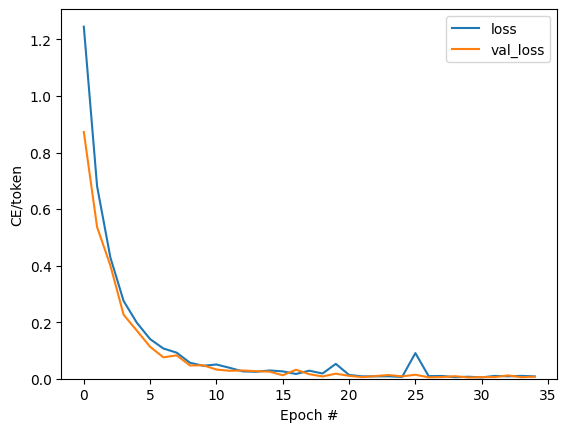

In [28]:
# Plotting training and validation loss
plt.plot(history.history['loss'], label='loss')  # Training loss over epochs
plt.plot(history.history['val_loss'], label='val_loss')  # Validation loss over epochs

# Setting y-axis limit to maintain consistency
plt.ylim([0, max(plt.ylim())])

# Labeling the axes
plt.xlabel('Epoch #')  # X-axis label indicating epoch number
plt.ylabel('CE/token')  # Y-axis label indicating cross-entropy per token

# Displaying legend for clarity
plt.legend()  # Show labels for 'loss' and 'val_loss' in the plot

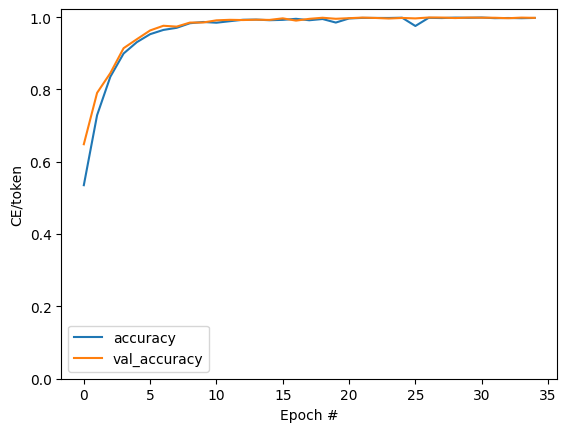

In [29]:
# Plotting training and validation accuracy
plt.plot(history.history['masked_acc'], label='accuracy')  # Training accuracy over epochs
plt.plot(history.history['val_masked_acc'], label='val_accuracy')  # Validation accuracy over epochs

# Setting y-axis limit to maintain consistency
plt.ylim([0, max(plt.ylim())])

# Labeling the axes
plt.xlabel('Epoch #')  # X-axis label indicating epoch number
plt.ylabel('CE/token')  # Y-axis label indicating cross-entropy per token

# Displaying legend for clarity
plt.legend()  # Show labels for 'accuracy' and 'val_accuracy' in the plot

In [30]:
correct = 0
accuracy = 0
NN = len(train_inputs)

# Process the data in chunks of 1000, including the last chunk which may be smaller
for i in range(0, NN, 1000):
    inputs = train_inputs[i:i+1000]
    result = model.translate(tf.constant(inputs))
    for j in range(len(inputs)):  # Use len(inputs) to handle the last smaller batch
        input_sentence = train_inputs[i+j]
        output_sentence = train_outputs[i+j]
        predicted_sentence = result[j].numpy().decode()
        if predicted_sentence.strip() == output_sentence.strip():
            correct += 1

print(f"accuracy = {correct*100/NN:.2f}%")

accuracy = 97.11%


In [31]:
correct = 0
accuracy = 0
NN = len(val_inputs)

# Process the data in chunks of 1000, including the last chunk which may be smaller
for i in range(0, NN, 1000):
    inputs = val_inputs[i:i+1000]
    result = model.translate(tf.constant(inputs))
    for j in range(len(inputs)):  # Use len(inputs) to handle the last smaller batch
        input_sentence = val_inputs[i+j]
        output_sentence = val_outputs[i+j]
        predicted_sentence = result[j].numpy().decode()
        if predicted_sentence.strip() == output_sentence.strip():
            correct += 1

print(f"accuracy = {correct*100/NN:.2f}%")

accuracy = 97.04%


In [32]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [33]:
export = Export(model)

In [34]:
inputs = train_inputs[:5]
_ = export.translate(tf.constant(inputs))

In [35]:
result = export.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

c e b d c f b d a h e f g c f a e i a f h j a g d k                                                                          
c e b d c f c e b d a h f g h b d b d b d c d a d l m a h j k ed a f i ee a h d e ef                                                           
c g b d a e e c f b d b d a d h i a f g j b d a f k l b d a h f m ed b d a h d ee ef                                                           



In [36]:
# Save the model using tf.saved_model.save
tf.saved_model.save(
    export,  # Exported module to be saveds
    '/gdrive/MyDrive/Colab Notebooks/translator.tf',  # Filepath to save the model
    signatures={'serving_default': export.translate}  # Define a serving signature for the model
)